# ACR Phantom Gradients Using Circularity

In [1]:
import numpy as np
from mriqa.phantoms import phantom_mask_2d, find_phantom
from mriqa.tools import show_mosaic
from mriqa.dcmio import fetch_series
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed

In [2]:
# ACR scan 2mm slice SE for orientation
patid = 'PQACRY20160411RHD'
stuid = '1'
sernos = [10]
dobjs = fetch_series(patid, stuid, sernos)

images = [d.pixel_array & 0x0fff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)

interpolation_factor = 4
images = [rescale_intensity(zoom(image, interpolation_factor)) for image in images]
pix_dims /= interpolation_factor


print(pix_dims, images[0].shape)

[0.12207031 0.12207031] (2048, 2048)


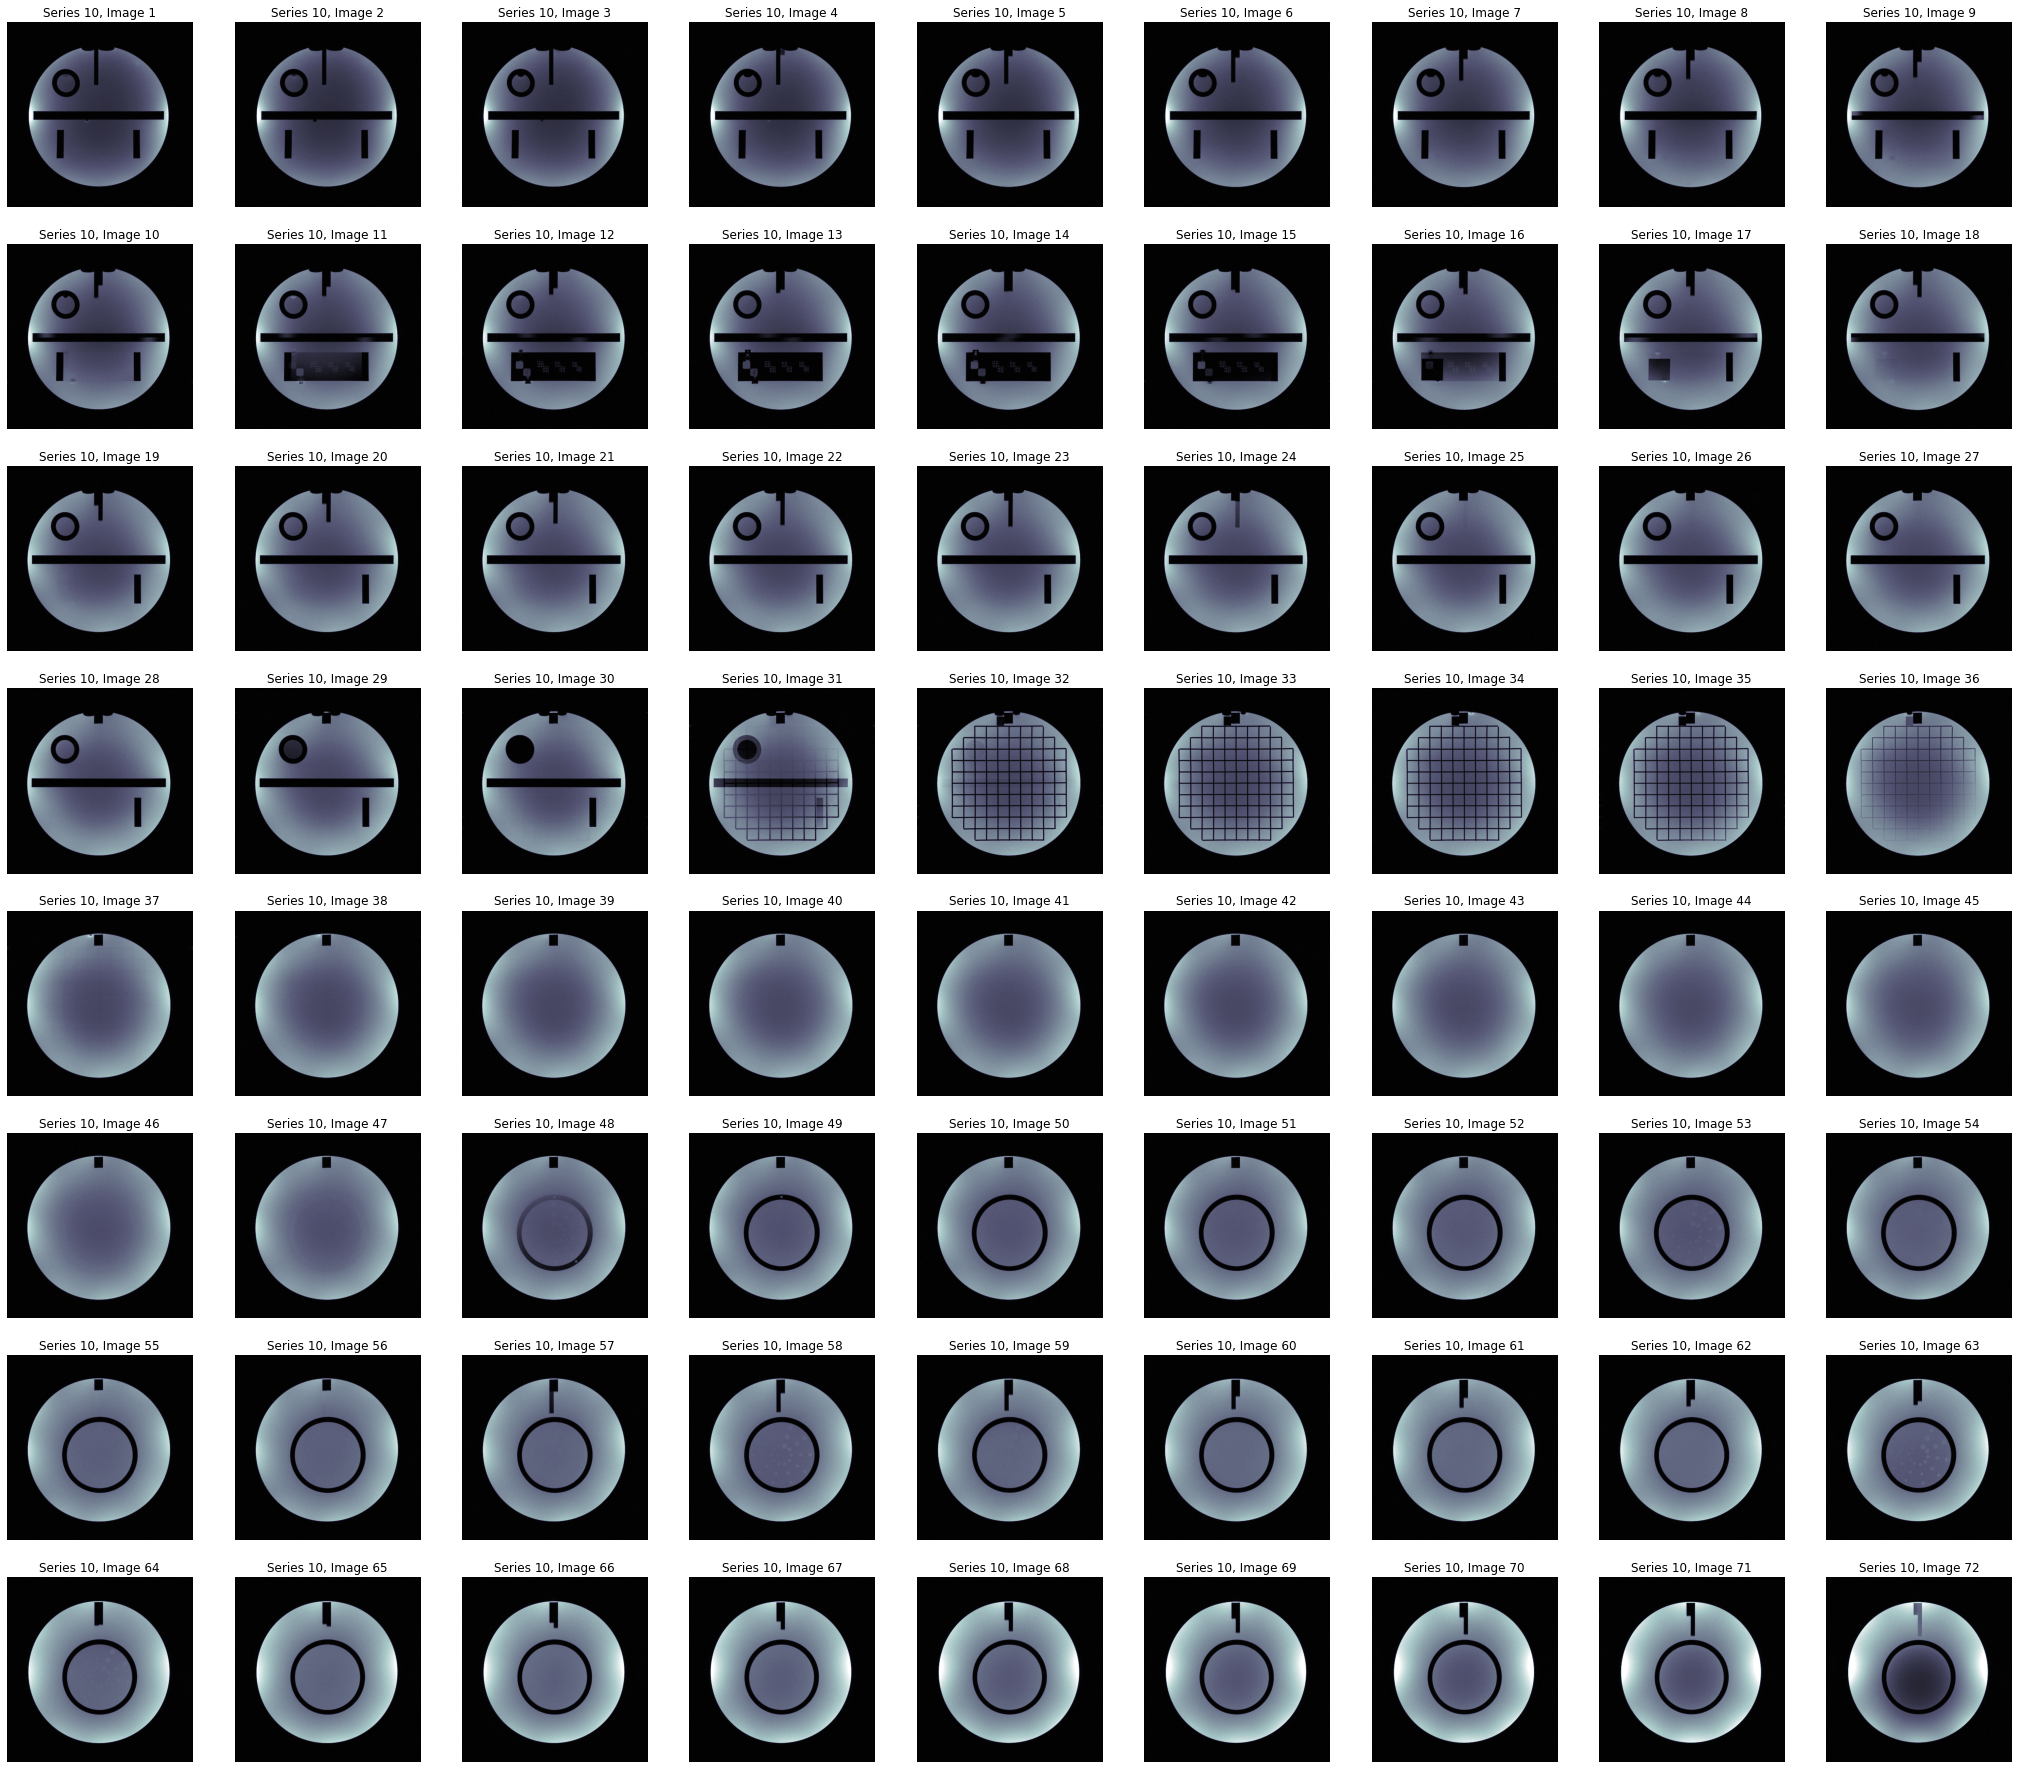

In [3]:
show_mosaic(dobjs, cmap='bone')

## Gradient Measurements
### General Notes
There details in the [accreditation instructions](http://www.acr.org/~/media/ACR/Documents/Accreditation/MRI/LargePhantomGuidance.pdf).

This is the ACR *Large* phantom (190mm diameter, length 148mm) - filled with 10mM NiCl<sub>2</sub>, 75mM NaCl.

We could use a perfectly aligned template to remove small rotations and shifts. Gross errors
should be avoidable as there are unambiguous set up marks on the phantom. They seem to use multiple series (T<sub>1</sub>W, T<sub>2</sub>W etc) with quite course slices (5mm + 3mm). They recommend twiddling the windowing
when making measurements - we can probably do this in a more principled way.

### Gradient Strength Calibration
For these they measure the size of the phantom so we'll want
 - Full slice coverage (or a non-axial view)
 - Sufficient BW in S/S and R/O to minimise B<sub>0</sub> effects on scale/distortion
 - Relatively easy to do with edge detection and peak location
 - In-plane they take diameters at 4 angles at the level of the distortion grid
 - Expect 190mm &oslash; by 140mm  &plusmn;2mm
 - NB gradient amplifier warm up effects (really? for solid state amps?)

### Slice Position (Laser/Couch offset)
 - Crossed (45&deg;) wedges at top and bottom ends of phantom (strange - not the middle?)
   - this way they can be used for the length as well
 - Two vertical bars should be the same height - (Anat)-L bar longer => slice is SUP.
 - Slice displacement is half difference in height between bars
 - Careful to make block symmetric or turn off couch centring mode
 - Actually seem to be at -45mm and +55mm (asymmetric!)

It's not very clear what the tube in the anterior-foot part of the phantom is. Also we don't know if the grid near the centre is accurate enough to be used for a distortion assessment.

We could do the cirularity test here, but we'll need to find a suitable slice and clean up the image so we get the edges properly. The uniform area 37-47 look like the easiest.

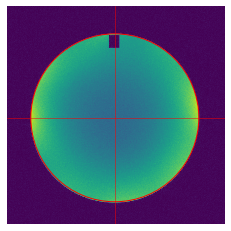

Interpolated Pixel Dimensions: 0.122 x 0.122 mm
Phantom Centre: 1013, 1049 pixels; Phantom Radius: 791 pixels, 96.56 mm


In [4]:
image = images[40].astype(float)

ACR40 = {
    'Diameter': 190
}

expected_radius = ACR40['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

plt.imshow(image, cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.grid(False)

plt.axvline(centre_x, linewidth=0.5, color='red')
plt.axhline(centre_y, linewidth=0.5, color='red')

circle  = plt.Circle((centre_x, centre_y), radius, color='red', fill=False)
plt.gcf().gca().add_artist(circle);
plt.show()

print('Interpolated Pixel Dimensions: %0.3f x %0.3f mm' % tuple(pix_dims))
print('Phantom Centre: %d, %d pixels; Phantom Radius: %d pixels, %0.2f mm' % (centre_x, centre_y, radius, radius*pix_dims[0]))


In [5]:
from scipy.ndimage import map_coordinates

def radial_profiles(image, centre, radius, ntheta=180, npoints=512, margin=1.25):
    """
    Sequence of radial profiles across diameter through the given centre over a range of angles.
    Image should already be interpolated up.
    """
    centre_x, centre_y =  centre

    # symmetrically about zero
    R = radius * margin
    theta = np.linspace(-np.pi/2, np.pi/2, ntheta)
    xas, yas = R * np.cos(theta), R * np.sin(theta)
    xbs, ybs = -xas, -yas

    # then add in offset to centre
    xas += centre_x
    xbs += centre_x
    yas += centre_y
    ybs += centre_y

    r = []
    for xa, xb, ya, yb in zip(xas, xbs, yas, ybs):
        x = np.linspace(xa, xb, npoints)
        y = np.linspace(ya, yb, npoints)
        r.append(map_coordinates(image, np.vstack((y, x))))
    r =  np.asarray(r)

    delta_r = 2 * R / npoints
    
    return r, theta, delta_r

In [6]:
def plot_profile_images(r):
    nprofiles, npoints = r.shape

    # derivatives of profiles
    dr = np.gradient(r, axis=-1)

    # derivatives with negative edge flipped positive (better than just abs())
    split = npoints // 2
    sdr = dr.copy()
    sdr[:, split:] *= -1

    # second derivative
    ddr = np.gradient(sdr, axis=-1)

    # plots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()

    axs[0].imshow(r, cmap='viridis')
    axs[0].axis('off')
    axs[0].grid(False)

    axs[1].imshow(dr, cmap='coolwarm')
    axs[1].axis('off')
    axs[1].grid(False)

    axs[2].imshow(sdr, cmap='viridis')
    axs[2].axis('off')
    axs[2].grid(False)

    axs[3].imshow(ddr, cmap='coolwarm')
    axs[3].axis('off')
    axs[3].grid(False)

    fig.tight_layout()

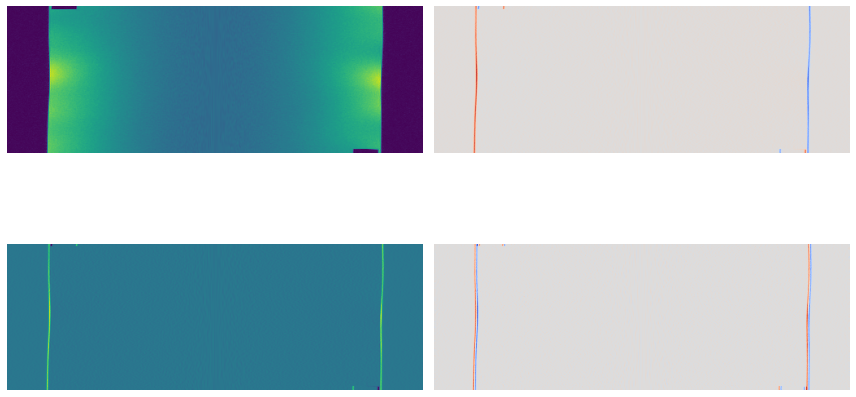

In [7]:
# We assume an isotropic image
assert pix_dims[0] == pix_dims[1]
plot_profile_images(radial_profiles(image, (centre_x, centre_y), radius)[0])

In [8]:
def plot_profiles_overlaid(r):
    nprofiles, npoints = r.shape
    # derivatives of profiles
    dr = np.gradient(r, axis=-1)
    
    # derivatives with negative edge flipped positive (better than just abs())
    split = npoints // 2
    sdr = dr.copy()
    sdr[:, split:] *= -1

    # second derivative
    ddr = np.gradient(sdr, axis=-1)

    # plots (with the middle parts of the profiles excised for clarity)
    fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
    axs = axs.ravel()

    l0, l1 = npoints//16, 3*npoints//16
    r0, r1 = 13*npoints//16, 15*npoints//16
    alpha = 5/nprofiles
    for profile in r:
        axs[0].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)

    axs[0].axis('tight')
    axs[0].set_title(r'$S(r)$')
    axs[0].grid(True)

    for profile in dr:
        axs[1].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)
    axs[1].axis('tight');
    axs[1].set_title(r'$\mathrm{d}S / \mathrm{d}r$')
    axs[1].grid(True)

    for profile in sdr:
        axs[2].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)
    axs[2].axis('tight');
    axs[2].set_title(r'Symmetrised $\mathrm{d}S / \mathrm{d}r$')
    axs[2].set_xlabel('Index Position in Profiles')
    axs[2].grid(True)

    for profile in ddr:
        axs[3].plot(np.hstack([profile[l0:l1], profile[r0:r1]]), '-', alpha=alpha)
    axs[3].axis('tight');
    axs[3].set_title(r'$\mathrm{d}^2S / \mathrm{d}r^2$')
    axs[3].set_xlabel('Index Position in Profiles')
    axs[3].grid(True)
 
    fig.tight_layout()

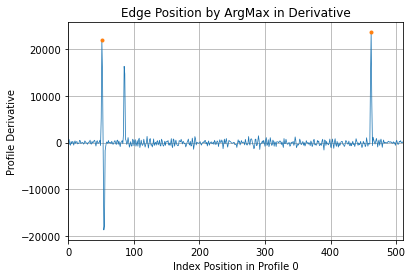

In [9]:
def positive_gradient(r):
    # flip sign of second edge to make both positive]
    nprofiles, npoints = r.shape
    dr = np.gradient(r, axis=-1)
    # derivatives with negative edge flipped positive (better than just abs())
    split = npoints // 2
    dr[:, split:] *= -1 
    return dr

sdr = positive_gradient(radial_profiles(image, (centre_x, centre_y), radius)[0])
split = sdr.shape[1] // 2
n = 0
x0 = np.argmax(sdr[n][:split])
x1 = np.argmax(sdr[n][split:]) + split

plt.plot(sdr[n], '-', alpha=1.0, linewidth=0.75)
plt.plot([x0, x1], [sdr[n][x0], sdr[n][x1]], '.')
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('Index Position in Profile %d' % n)
plt.ylabel('Profile Derivative')
plt.grid(True)
plt.title('Edge Position by ArgMax in Derivative');

In [10]:
from scipy.optimize import curve_fit
from warnings import warn

def gaussian_fit(x, y):
    def gaussian(x, ampl, centre, stdev):
        return ampl * np.exp(-(x - float(centre)) ** 2 / (2.0 * stdev ** 2 + np.finfo(float).eps))
    
    if len(x) < 3:
        raise RuntimeError("At least 3 points required for Gaussian fitting")

    ampl_0, centre_0, stddev_0 = np.max(y), (x[0] + x[-1])/2, (x[1] - x[0]) * 2
    initial = [ampl_0, centre_0, stddev_0]
    lower_bounds = [0.75 * ampl_0, centre_0 - 2.0, stddev_0 / 4]
    upper_bounds = [1.25 * ampl_0, centre_0 + 2.0, 2 * stddev_0]
    
    try:
        params, _ = curve_fit(gaussian, x, y, initial, xtol=0.01, bounds=(lower_bounds, upper_bounds))
    except RuntimeError as e:
        # print(window, index)
        warn("gaussian_fit: fitting error [%s] (trying a looser tolerance)" % e)
        params, _ = curve_fit(gaussian, x, y, initial, xtol=0.25, bounds=(lower_bounds, upper_bounds))
    return params[1]


def refine_peak(row, index, window_half_width=8):
    """
    Refine a peak position previously determined with argmax
    """
    if not (window_half_width <= index < len(row) + window_half_width, index):
        warn('peak too close to edge in refine_peak')
        return float(index)

    # centre window on previsously detected peak
    y = row[index-window_half_width:index+window_half_width]
    x = np.arange(len(y))
    
    # try and fit a gaussian
    try:
        return gaussian_fit(x, y) + index - window_half_width
    except RuntimeError as e:
        warn("refine_peak: %s" % e)
        return float(index)

In [11]:
x0_x1 = []

r, theta, delta_r = radial_profiles(image, (centre_x, centre_y), radius)
for line in positive_gradient(r):
    x0 = refine_peak(line[:split], np.argmax(line[:split]))
    x1 = refine_peak(line[split:], np.argmax(line[split:])) + split
    x0_x1.append((x0, x1))

x0, x1 = np.array(x0_x1).T
dx = x1 - x0

# fit a single cycle sinusoid of arbitrary phase
# we are assuming here that the profiles cover a range of angle over exactly a semi-circle
def sinfit(x, offset, a, b):
    phase = np.arange(len(x)) * 2 * np.pi / len(x)
    return offset + a * np.cos(phase) + b * np.sin(phase)

offset, a, b = curve_fit(sinfit, xdata=theta, ydata=dx, p0=(dx.mean(), 0, 0))[0]
dxfit = sinfit(dx, offset, a, b)
devn_fit = np.ptp(dxfit) / 2
devn_raw = np.ptp(dx) / 2

delta_r_mm = delta_r * pix_dims[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(np.degrees(theta), x0*delta_r_mm)
axs[0].plot(np.degrees(theta), x1*delta_r_mm)
axs[0].text(-80, ((x0+x1)/2*delta_r_mm).mean(), r'$\mathrm{Mean Diameter: } %0.1f \mathrm{ mm}$' % (dx.mean()*delta_r_mm))
axs[0].set_xlabel(r'Angle $\theta^\circ$')
axs[0].set_ylabel(r'Profile Position (mm)')
axs[0].autoscale(enable=True, axis='x', tight=True)
axs[0].grid(True)
axs[1].plot(np.degrees(theta), dx*delta_r_mm, '.');
axs[1].plot(np.degrees(theta), dxfit*delta_r_mm, '-');
axs[1].text(-80, dxfit.min()*delta_r_mm, r'$\mathrm{Fitted Deviation: } \pm %0.2f \mathrm{ mm}$' % (devn_fit*delta_r_mm))
axs[1].text(-50, dx.min()*delta_r_mm, r'$\mathrm{Raw Deviation: } \pm %0.2f \mathrm{ mm}$' % (devn_raw*delta_r_mm))
axs[1].set_xlabel(r'Angle $\theta^\circ$')
axs[1].set_ylabel(r'Profile Length (mm)')
axs[1].axis('tight')
axs[1].grid(True);

The fit could be better - maybe we should use extra harmonics. Still, &pm;0.7mm is not that bad.

Note though that the scale is slightly *wrong*, that is 193mm vs 190mm - about **1.6%** too large. That would corresond to a volume error of nearly 5% so not insignificant in some contexts.